In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)

In [2]:
bike_df = pd.read_csv('bike_train.csv')

In [3]:
bike_df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

In [6]:
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1


In [7]:
bike_df.drop(columns=['datetime','casual','registered'],
             inplace=True)

In [8]:
bike_df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y-log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_v = rmsle(y,pred)
    rmse_v = rmse(y,pred)
    mae = mean_absolute_error(y,pred)
    print(f'rmsle:{rmsle_v:.3f},rmse:{rmse_v:.3f},mae:{mae:.3f}')

In [21]:
bike_df.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1


In [22]:
# 회귀 모델을 적용하기 전에 데이터 세트에 대해 먼저 처리할 것은 결과값이 정규분포로 되어 있는지와 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩하는 것

In [23]:
from sklearn.model_selection import train_test_split,GridSearchCV # GridSearchCV: 교차검증과 동시에 파라미터 튜닝
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [24]:
y = bike_df['count']
X = bike_df.drop(columns=['count']) # 원본에 덮어쓰려면 inplace
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size =0.3,
                                                    random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test,pred)

rmsle:1.165,rmse:140.900,mae:105.924


In [27]:
bike_df['count'].max()

977

In [31]:
def get_top_error_data(y_test,pred,n_tops=5):
    result_df = pd.DataFrame(y_test.values,columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])
    print(result_df.sort_values('diff',ascending=False)[:n_tops])

In [32]:
get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

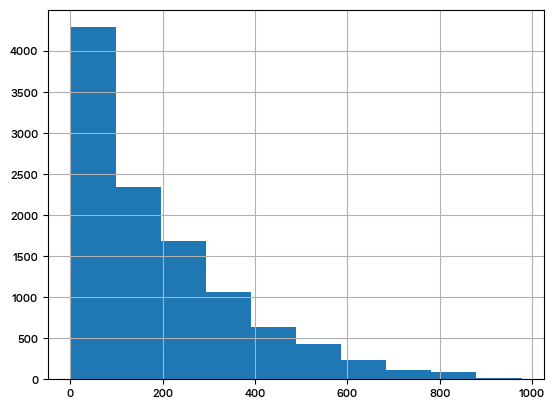

In [33]:
y.hist()

<AxesSubplot:>

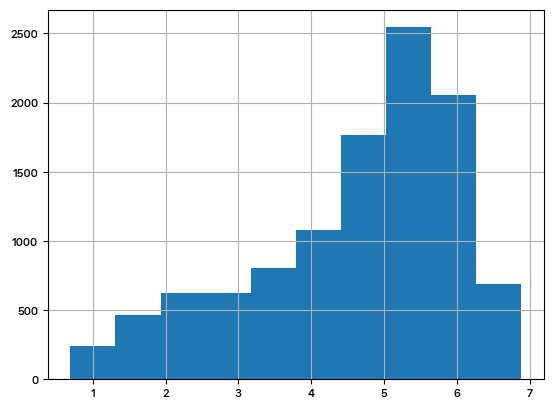

In [35]:
y_log = np.log1p(y)
y_log.hist()

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_log,
                                                    test_size =0.3,
                                                    random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
evaluate_regr(y_test_exp,pred_exp)
# rmsle:1.165,rmse:140.900,mae:105.924

rmsle:1.017,rmse:162.594,mae:109.286


In [42]:
get_top_error_data(y_test_exp,pred_exp,n_tops=5)

      real_count  predicted_count   diff
2199       201.0            913.0  712.0
3151       798.0            114.0  684.0
2314       766.0             96.0  670.0
412        745.0             78.0  667.0
2003       770.0            106.0  664.0


<AxesSubplot:>

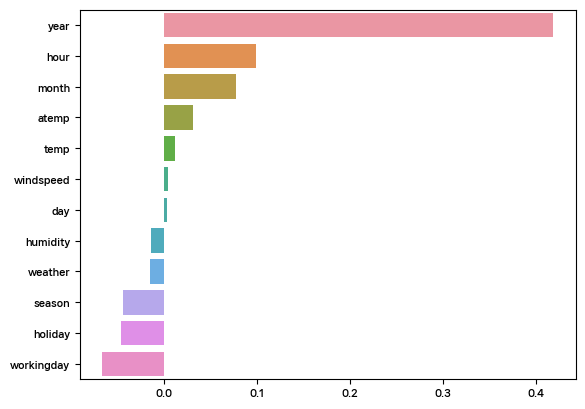

In [43]:
coef = pd.Series(lr_reg.coef_,index=X.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)

In [44]:
X_ohe = pd.get_dummies(X, columns = ['year',
                                     'month',
                                     'day',
                                     'hour',
                                     'holiday',
                                     'workingday',
                                     'season',
                                     'weather'])

In [45]:
X_ohe.head(1)

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe,
                                                    y_log,
                                                    test_size =0.3,
                                                    random_state=0)
def get_model_predict(model,
                      X_train,
                      X_test,
                      y_train,
                      y_test,
                      is_expm1=False):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('######',model.__class__.__name__,'######')
    evaluate_regr(y_test,pred)

In [53]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)
for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,
                      X_train,
                      X_test,
                      y_train,
                      y_test,
                      is_expm1=True)
# rmsle:1.165,rmse:140.900,mae:105.924 - 선형회귀 적용
# rmsle:1.017,rmse:162.594,mae:109.286 - y값 log 변환 적용

###### LinearRegression ######
rmsle:0.590,rmse:97.688,mae:63.382
###### Ridge ######
rmsle:0.590,rmse:98.529,mae:63.893
###### Lasso ######
rmsle:0.635,rmse:113.219,mae:72.803


<AxesSubplot:>

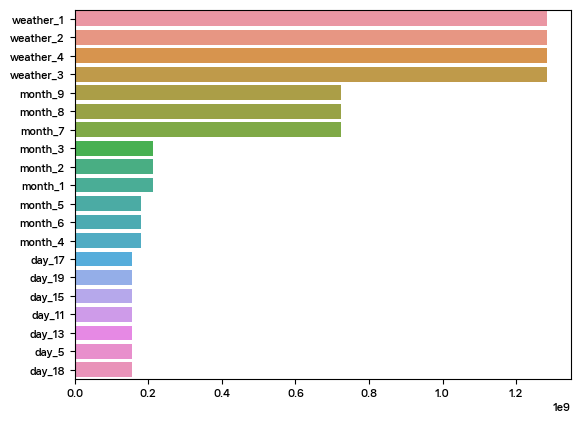

In [55]:
coef = pd.Series(lr_reg.coef_,index=X_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values,y=coef_sort.index)